# Exécution: LS (LS2) et AG (AG2) pour n=100

Ce notebook exécute directement les implémentations présentes dans `FP_LS(n=100).ipynb` et `FP_AG_n=100.ipynb` pour les configurations `LS2` et `AG2` (n = 100). Aucune lecture de CSV n'est utilisée — les runs sont effectués ici et les résultats affichés.

In [1]:
# Imports nécessaires
# Si jmetalpy ou d'autres paquets manquent, installez-les avant d'exécuter ce notebook
from jmetal.algorithm.singleobjective.local_search import LocalSearch
from jmetal.operator.mutation import PolynomialMutation
from jmetal.operator.crossover import SBXCrossover
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.core.problem import Problem
from jmetal.core.solution import FloatSolution
import random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
print('Imports ready')

Imports ready


In [2]:
# Définition du problème (copié des notebooks sources)
class FloatPairsMax(Problem):
    def __init__(self, number_of_floats: int, min_value: float, max_value: float):
        super().__init__()
        self.number_of_floats = number_of_floats
        self.min_value = min_value
        self.max_value = max_value
        self.lower_bound = [self.min_value] * number_of_floats
        self.upper_bound = [self.max_value] * number_of_floats
        self.number_of_objectives = 1
        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ['NegativePairsCount']
    def number_of_variables(self) -> int:
        return self.number_of_floats
    def number_of_objectives(self) -> int:
        return 1
    def number_of_constraints(self) -> int:
        return 0
    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        variables = solution.variables
        pairs_count = 0
        for i in range(len(variables) - 1):
            if (variables[i] * variables[i + 1] < 0) or (variables[i] == 0 and variables[i + 1] < 0) or (variables[i + 1] == 0 and variables[i] < 0):
                pairs_count += 1
        solution.objectives[0] = -pairs_count
        return solution
    def create_solution(self) -> FloatSolution:
        new_solution = FloatSolution(self.lower_bound, self.upper_bound, self.number_of_objectives, self.number_of_constraints())
        new_solution.variables = [random.uniform(self.lower_bound[i], self.upper_bound[i]) for i in range(self.number_of_variables())]
        return new_solution
    def name(self) -> str:
        return 'FloatPairsMax'
print('Problem class defined')

Problem class defined


In [3]:
# Fonctions d'exécution (LS et AG) — réutilisées des notebooks sources
def run_local_search(problem, config, max_evaluations, verbose=False):
    mutation_prob = config['mutation_probability']
    if mutation_prob is None:
        mutation_prob = 1.0 / problem.number_of_variables()
    mutation = PolynomialMutation(probability=mutation_prob, distribution_index=config['mutation_distribution_index'])
    algorithm = LocalSearch(problem=problem, mutation=mutation, termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations))
    start_time = time.time()
    algorithm.run()
    exec_time = time.time() - start_time
    result = algorithm.result()
    fitness = result.objectives[0]
    if verbose:
        print(f'  Fitness: {fitness} ({-fitness} paires) | Time: {exec_time:.4f}s')
    return fitness, exec_time

def run_genetic_algorithm(problem, config, max_evaluations, verbose=False):
    mutation = PolynomialMutation(probability=config['mutation_probability'], distribution_index=config['mutation_distribution_index'])
    crossover = SBXCrossover(probability=config['crossover_probability'], distribution_index=config['crossover_distribution_index'])
    algorithm = GeneticAlgorithm(problem=problem, population_size=config['population_size'], offspring_population_size=config['offspring_population_size'], mutation=mutation, crossover=crossover, termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations))
    start_time = time.time()
    algorithm.run()
    exec_time = time.time() - start_time
    result = algorithm.result()
    fitness = result.objectives[0]
    if verbose:
        print(f'  Fitness: {fitness} ({-fitness} paires) | Time: {exec_time:.4f}s')
    return fitness, exec_time

print('Run functions defined')

Run functions defined


In [4]:
# Paramètres expérimentaux (n=100)
N_FLOATS = 100
MIN_VALUE = -10.0
MAX_VALUE = 10.0
OPTIMAL_VALUE = -(N_FLOATS - 1)
MAX_EVALUATIONS = 5000
N_RUNS = 20

# Configuration LS2 (extraite de FP_LS(n=100).ipynb)
ls_config = {
    'nom': 'Mutation faible (0.25)',
    'mutation_probability': 0.25,
    'mutation_distribution_index': 20.0,
}

# Configuration AG2 (extraite de FP_AG_n=100.ipynb)
ag_config = {
    'nom': 'Population doublée',
    'population_size': 100,
    'offspring_population_size': 100,
    'mutation_probability': 1.0 / N_FLOATS,
    'mutation_distribution_index': 20.0,
    'crossover_probability': 0.9,
    'crossover_distribution_index': 20.0,
}

print('Configurations ready for LS2 and AG2')

Configurations ready for LS2 and AG2


In [5]:
# Exécuter LS (LS2)
problem_ls = FloatPairsMax(number_of_floats=N_FLOATS, min_value=MIN_VALUE, max_value=MAX_VALUE)
ls_fitness = []
ls_times = []
print('Running LS2:', ls_config['nom'])
for i in range(N_RUNS):
    f, t = run_local_search(problem_ls, ls_config, MAX_EVALUATIONS, verbose=False)
    ls_fitness.append(f)
    ls_times.append(t)
    print(f'LS run {i+1}/{N_RUNS}: pairs = {-f}, time = {t:.4f}s')

# Stocker résultats LS
ls_results = {
    'fitness_values': ls_fitness,
    'execution_times': ls_times,
    'mean': np.mean(ls_fitness),
    'median': np.median(ls_fitness),
    'std': np.std(ls_fitness),
    'min': np.min(ls_fitness),
    'max': np.max(ls_fitness),
    'time_mean': np.mean(ls_times),
    'time_std': np.std(ls_times),
    'success_rate': sum(1 for f in ls_fitness if f == OPTIMAL_VALUE) / N_RUNS * 100,
}
print('LS2 completed')

[2026-02-02 12:04:53,304] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:04:53,305] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:04:53,306] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:04:53,307] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Running LS2: Mutation faible (0.25)


[2026-02-02 12:04:54,566] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:04:54,567] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:04:54,568] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:04:54,570] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:04:54,571] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 1/20: pairs = 92, time = 1.2635s


[2026-02-02 12:04:55,259] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:04:55,259] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:04:55,260] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:04:55,260] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:04:55,261] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 2/20: pairs = 89, time = 0.6920s


[2026-02-02 12:04:55,905] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:04:55,906] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:04:55,906] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:04:55,907] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:04:55,907] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 3/20: pairs = 87, time = 0.6465s


[2026-02-02 12:04:56,502] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:04:56,503] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:04:56,503] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:04:56,504] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:04:56,504] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 4/20: pairs = 90, time = 0.5966s


[2026-02-02 12:04:57,122] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:04:57,123] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:04:57,123] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:04:57,123] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:04:57,125] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 5/20: pairs = 88, time = 0.6200s


[2026-02-02 12:04:57,722] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:04:57,723] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:04:57,724] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:04:57,725] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:04:57,725] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 6/20: pairs = 89, time = 0.6003s


[2026-02-02 12:04:58,327] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:04:58,328] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:04:58,329] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:04:58,329] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:04:58,330] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 7/20: pairs = 89, time = 0.6048s


[2026-02-02 12:04:58,934] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:04:58,935] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:04:58,935] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:04:58,936] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:04:58,936] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 8/20: pairs = 89, time = 0.6067s


[2026-02-02 12:04:59,535] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:04:59,536] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:04:59,536] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:04:59,537] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:04:59,537] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 9/20: pairs = 87, time = 0.6010s


[2026-02-02 12:05:00,161] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:00,161] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:00,162] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:00,162] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:00,162] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 10/20: pairs = 87, time = 0.6255s


[2026-02-02 12:05:00,778] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:00,779] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:00,780] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:00,780] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:00,781] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 11/20: pairs = 93, time = 0.6179s


[2026-02-02 12:05:01,377] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:01,378] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:01,378] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:01,379] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:01,380] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 12/20: pairs = 89, time = 0.5988s


[2026-02-02 12:05:02,017] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:02,018] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:02,018] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:02,019] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:02,020] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 13/20: pairs = 91, time = 0.6395s


[2026-02-02 12:05:02,644] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:02,645] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:02,645] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:02,645] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:02,646] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 14/20: pairs = 88, time = 0.6268s


[2026-02-02 12:05:03,242] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:03,242] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:03,243] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:03,243] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:03,244] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 15/20: pairs = 90, time = 0.5978s


[2026-02-02 12:05:03,839] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:03,840] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:03,841] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:03,842] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:03,843] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 16/20: pairs = 91, time = 0.5976s


[2026-02-02 12:05:04,435] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:04,436] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:04,436] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:04,437] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:04,437] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 17/20: pairs = 86, time = 0.5954s


[2026-02-02 12:05:05,022] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:05,022] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:05,023] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:05,024] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:05,024] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 18/20: pairs = 87, time = 0.5866s


[2026-02-02 12:05:05,637] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:05,638] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:05,638] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:05,639] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:05,639] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


LS run 19/20: pairs = 91, time = 0.6154s


[2026-02-02 12:05:06,235] [jmetal.core.algorithm] [DEBUG] Finished!


LS run 20/20: pairs = 88, time = 0.5977s
LS2 completed


In [6]:
# Exécuter AG (AG2)
problem_ag = FloatPairsMax(number_of_floats=N_FLOATS, min_value=MIN_VALUE, max_value=MAX_VALUE)
ag_fitness = []
ag_times = []
print('Running AG2:', ag_config['nom'])
for i in range(N_RUNS):
    f, t = run_genetic_algorithm(problem_ag, ag_config, MAX_EVALUATIONS, verbose=False)
    ag_fitness.append(f)
    ag_times.append(t)
    print(f'AG run {i+1}/{N_RUNS}: pairs = {-f}, time = {t:.4f}s')

# Stocker résultats AG
ag_results = {
    'fitness_values': ag_fitness,
    'execution_times': ag_times,
    'mean': np.mean(ag_fitness),
    'median': np.median(ag_fitness),
    'std': np.std(ag_fitness),
    'min': np.min(ag_fitness),
    'max': np.max(ag_fitness),
    'time_mean': np.mean(ag_times),
    'time_std': np.std(ag_times),
    'success_rate': sum(1 for f in ag_fitness if f == OPTIMAL_VALUE) / N_RUNS * 100,
}
print('AG2 completed')

[2026-02-02 12:05:06,247] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:06,251] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:06,254] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:06,254] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Running AG2: Population doublée


[2026-02-02 12:05:07,553] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:07,555] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:07,558] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:07,562] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:07,563] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 1/20: pairs = 84, time = 1.3071s


[2026-02-02 12:05:08,674] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:08,675] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:08,679] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:08,681] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:08,681] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 2/20: pairs = 87, time = 1.1198s


[2026-02-02 12:05:09,749] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:09,750] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:09,753] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:09,754] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:09,755] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 3/20: pairs = 87, time = 1.0753s


[2026-02-02 12:05:10,674] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:10,675] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:10,677] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:10,679] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:10,680] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 4/20: pairs = 81, time = 0.9240s


[2026-02-02 12:05:11,726] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:11,727] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:11,729] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:11,731] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:11,732] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 5/20: pairs = 92, time = 1.0519s


[2026-02-02 12:05:12,765] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:12,766] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:12,769] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:12,770] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:12,771] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 6/20: pairs = 81, time = 1.0385s


[2026-02-02 12:05:14,468] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:14,470] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:14,473] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:14,476] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:14,477] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 7/20: pairs = 82, time = 1.7034s


[2026-02-02 12:05:15,592] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:15,593] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:15,596] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:15,598] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:15,599] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 8/20: pairs = 82, time = 1.1228s


[2026-02-02 12:05:16,705] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:16,706] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:16,709] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:16,711] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:16,711] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 9/20: pairs = 87, time = 1.1131s


[2026-02-02 12:05:17,816] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:17,819] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:17,826] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:17,829] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:17,831] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 10/20: pairs = 88, time = 1.1113s


[2026-02-02 12:05:19,081] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:19,082] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:19,084] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:19,086] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:19,086] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 11/20: pairs = 81, time = 1.2630s


[2026-02-02 12:05:19,915] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:19,916] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:19,918] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:19,920] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:19,920] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 12/20: pairs = 89, time = 0.8340s


[2026-02-02 12:05:20,781] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:20,782] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:20,784] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:20,785] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:20,786] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 13/20: pairs = 90, time = 0.8655s


[2026-02-02 12:05:21,695] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:21,696] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:21,698] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:21,700] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:21,700] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 14/20: pairs = 87, time = 0.9142s


[2026-02-02 12:05:22,555] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:22,557] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:22,560] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:22,562] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:22,563] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 15/20: pairs = 84, time = 0.8597s


[2026-02-02 12:05:23,437] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:23,438] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:23,440] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:23,441] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:23,442] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 16/20: pairs = 82, time = 0.8808s


[2026-02-02 12:05:24,283] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:24,284] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:24,286] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:24,288] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:24,288] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 17/20: pairs = 85, time = 0.8460s


[2026-02-02 12:05:25,100] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:25,101] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:25,103] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:25,104] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:25,105] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 18/20: pairs = 85, time = 0.8165s


[2026-02-02 12:05:26,008] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 12:05:26,008] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:05:26,010] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:05:26,012] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:05:26,013] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


AG run 19/20: pairs = 89, time = 0.9074s


[2026-02-02 12:05:26,847] [jmetal.core.algorithm] [DEBUG] Finished!


AG run 20/20: pairs = 86, time = 0.8388s
AG2 completed


,Algorithm,Mean_fitness,Mean_pairs,Median,Std,SuccessRate(%),Time_mean(s)
0,LS2,-89.05,89.05,-89.0,1.829617,0.0,0.646517
1,AG2,-85.45,85.45,-85.5,3.201172,0.0,1.029654


/var/folders/rh/xt3snpjn7ng64htp00_8m9nw0000gn/T/ipykernel_50151/1934398599.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_boxplot, labels=['LS2','AG2'], patch_artist=True, showmeans=True)


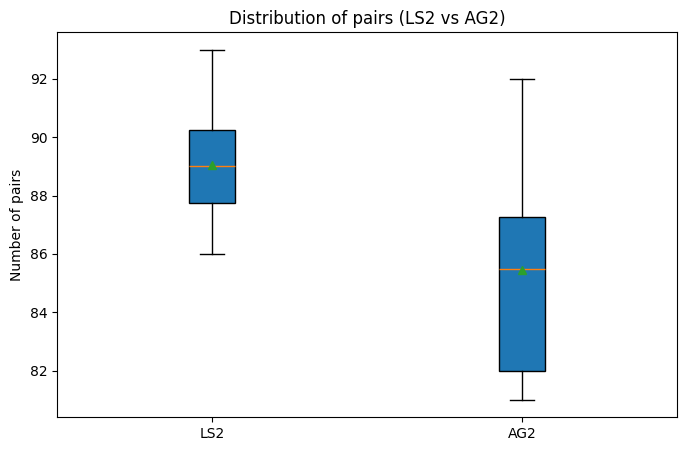

Mann-Whitney U test: U=327.50, p=0.0005
Comparison complete


In [7]:
# Synthèse et comparaison
summary = pd.DataFrame([
    {
        'Algorithm': 'LS2',
        'Mean_fitness': ls_results['mean'],
        'Mean_pairs': -ls_results['mean'],
        'Median': ls_results['median'],
        'Std': ls_results['std'],
        'SuccessRate(%)': ls_results['success_rate'],
        'Time_mean(s)': ls_results['time_mean']
    },
    {
        'Algorithm': 'AG2',
        'Mean_fitness': ag_results['mean'],
        'Mean_pairs': -ag_results['mean'],
        'Median': ag_results['median'],
        'Std': ag_results['std'],
        'SuccessRate(%)': ag_results['success_rate'],
        'Time_mean(s)': ag_results['time_mean']
    }
])
display(summary)

# Boxplot comparatif des distributions de paires (valeurs positives)
fig, ax = plt.subplots(figsize=(8,5))
data_for_boxplot = [[-v for v in ls_results['fitness_values']], [-v for v in ag_results['fitness_values']]]
ax.boxplot(data_for_boxplot, labels=['LS2','AG2'], patch_artist=True, showmeans=True)
ax.set_ylabel('Number of pairs')
ax.set_title('Distribution of pairs (LS2 vs AG2)')
plt.show()

# Test statistique simple (Mann-Whitney U) si SciPy disponible
try:
    from scipy.stats import mannwhitneyu
    u, p = mannwhitneyu([-v for v in ls_results['fitness_values']], [-v for v in ag_results['fitness_values']], alternative='two-sided')
    print(f'Mann-Whitney U test: U={u:.2f}, p={p:.4f}')
except Exception as e:
    print('SciPy not available or test failed:', e)

print('Comparison complete')

In [8]:
# Cellule améliorée : traces de convergence par évaluation + graphiques complets
# Cette cellule recalcule des traces best-so-far à l'échelle d'une évaluation
# (utiliser des valeurs réduites si vous voulez accélérer)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import copy

TRACE_EVALS = min(2000, MAX_EVALUATIONS)  # nombre d'évals à tracer pour chaque run
N_TRACE_RUNS = 5
DOWNSAMPLE_POINTS = 200  # nombre de points affichés sur la courbe

print(f'Trace settings: TRACE_EVALS={TRACE_EVALS}, N_TRACE_RUNS={N_TRACE_RUNS}, downsample to {DOWNSAMPLE_POINTS} points')

# Fonction qui retourne best-so-far pour chaque évaluation (LS simple)
def ls_best_per_eval(problem, mutation_prob, max_evals):
    current = problem.create_solution()
    current = problem.evaluate(current)
    best = -current.objectives[0]
    best_list = [best]
    evals = 1
    while evals < max_evals:
        # mutate a single neighbor candidate
        neighbor = copy.deepcopy(current)
        # mutate each variable with probability mutation_prob
        for i in range(problem.number_of_variables()):
            if np.random.rand() < mutation_prob:
                lo, hi = problem.lower_bound[i], problem.upper_bound[i]
                neighbor.variables[i] = np.random.uniform(lo, hi)
        neighbor = problem.evaluate(neighbor)
        evals += 1
        # accept if better (remember objectives are negative)
        if neighbor.objectives[0] < current.objectives[0]:
            current = neighbor
        best = max(best, -current.objectives[0])
        best_list.append(best)
    return np.array(best_list)

# Fonction GA best-so-far per eval (simplifié, counts per child evaluated)
def ga_best_per_eval(problem, pop_size, offspring_size, mutation_prob, max_evals):
    # init pop
    pop = [problem.create_solution() for _ in range(pop_size)]
    for s in pop:
        problem.evaluate(s)
    evals = pop_size
    best = max([-s.objectives[0] for s in pop])
    best_list = list(np.repeat(best, pop_size))[:pop_size]  # initial
    # continue generating offspring one by one until max_evals reached
    while evals < max_evals:
        # generate one child at a time
        p1 = pop[np.random.randint(0,len(pop))]
        p2 = pop[np.random.randint(0,len(pop))]
        child = problem.create_solution()
        child.variables = [p1.variables[i] if np.random.rand() < 0.5 else p2.variables[i] for i in range(problem.number_of_variables())]
        # mutation
        for i in range(problem.number_of_variables()):
            if np.random.rand() < mutation_prob:
                lo, hi = problem.lower_bound[i], problem.upper_bound[i]
                child.variables[i] = np.random.uniform(lo, hi)
        problem.evaluate(child)
        evals += 1
        # insert child and keep best pop_size
        pop.append(child)
        pop.sort(key=lambda s: s.objectives[0])
        pop = pop[:pop_size]
        best = max(best, -pop[0].objectives[0])
        best_list.append(best)
    return np.array(best_list)

# Générer traces (médiane + IQR)
ls_traces = []
ag_traces = []
for r in range(N_TRACE_RUNS):
    ls_traces.append(ls_best_per_eval(problem_ls, ls_config['mutation_probability'], TRACE_EVALS))
    ag_traces.append(ga_best_per_eval(problem_ag, ag_config['population_size'], ag_config['offspring_population_size'], ag_config['mutation_probability'], TRACE_EVALS))

# Aligner longueurs
min_len = min([len(t) for t in ls_traces + ag_traces])
ls_arr = np.vstack([t[:min_len] for t in ls_traces])
ag_arr = np.vstack([t[:min_len] for t in ag_traces])

# Downsample pour affichage
indices = np.linspace(0, min_len-1, num=min(DOWNSAMPLE_POINTS, min_len)).astype(int)
xs = indices + 1  # evaluations
ls_median = np.median(ls_arr[:, indices], axis=0)
ls_q1 = np.percentile(ls_arr[:, indices], 25, axis=0)
ls_q3 = np.percentile(ls_arr[:, indices], 75, axis=0)
ag_median = np.median(ag_arr[:, indices], axis=0)
ag_q1 = np.percentile(ag_arr[:, indices], 25, axis=0)
ag_q3 = np.percentile(ag_arr[:, indices], 75, axis=0)

plt.figure(figsize=(10,6))
plt.plot(xs, ls_median, color='#3498db', label='LS2 (median)')
plt.fill_between(xs, ls_q1, ls_q3, color='#3498db', alpha=0.2)
plt.plot(xs, ag_median, color='#e74c3c', label='AG2 (median)')
plt.fill_between(xs, ag_q1, ag_q3, color='#e74c3c', alpha=0.2)
plt.xlabel('Evaluations')
plt.ylabel('Meilleur nombre de paires trouvé')
plt.title('Courbe de convergence (médiane + IQR)')
plt.legend()
plt.grid(True)
plt.show()

# Recréer les autres graphiques demandés (boxplots finaux et temps, scatter)
# Boxplot fitness finaux
plt.figure(figsize=(8,5))
plt.boxplot([ls_pairs, ag_pairs], labels=['LS2','AG2'], patch_artist=True, showmeans=True)
plt.ylabel('Nombre de paires')
plt.title('Boxplot — Fitness finaux (nombre de paires)')
plt.show()

# Boxplot temps
plt.figure(figsize=(8,5))
plt.boxplot([ls_results['execution_times'], ag_results['execution_times']], labels=['LS2','AG2'], patch_artist=True, showmeans=True)
plt.ylabel("Temps d'exécution (s)")
plt.title("Boxplot — Temps d'exécution")
plt.show()

# Scatter fitness vs temps
plt.figure(figsize=(8,6))
plt.scatter(ls_results['execution_times'], ls_pairs, alpha=0.7, label='LS2', color='#3498db')
plt.scatter(ag_results['execution_times'], ag_pairs, alpha=0.7, label='AG2', color='#e74c3c')
# linear fit
all_times = np.array(ls_results['execution_times'] + ag_results['execution_times'])
all_pairs = np.array(ls_pairs + ag_pairs)
if len(all_times) > 1:
    coef = np.polyfit(all_times, all_pairs, 1)
    x_line = np.linspace(all_times.min(), all_times.max(), 100)
    y_line = np.polyval(coef, x_line)
    plt.plot(x_line, y_line, color='gray', linestyle='--', label=f'Linear fit: y={coef[0]:.3f}x+{coef[1]:.2f}')
plt.xlabel("Temps d'exécution (s)")
plt.ylabel('Nombre de paires')
plt.title('Relation — Fitness vs Temps d\'exécution')
plt.legend()
plt.grid(True)
plt.show()

print('All graphs generated')

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# Graphiques demandés (n=100, configs LS2 & AG2) — sans CSV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
except Exception:
    sns = None

if 'ls_results' not in globals() or 'ag_results' not in globals():
    raise RuntimeError(
        "ls_results/ag_results introuvables. Exécute d'abord les cellules 'Exécuter LS (LS2)' et 'Exécuter AG (AG2)'."
    )

ls_fitness = np.array(ls_results['fitness_values'], dtype=float)
ag_fitness = np.array(ag_results['fitness_values'], dtype=float)

# Interprétation: l'objectif est MINIMIZE(-pairs) => nombre de paires = -fitness
ls_pairs = (-ls_fitness).tolist()
ag_pairs = (-ag_fitness).tolist()

ls_times = np.array(ls_results['execution_times'], dtype=float)
ag_times = np.array(ag_results['execution_times'], dtype=float)

plot_df = pd.DataFrame(
    {
        'Algo': ['LS2'] * len(ls_pairs) + ['AG2'] * len(ag_pairs),
        'Pairs': ls_pairs + ag_pairs,
        'Fitness': ls_fitness.tolist() + ag_fitness.tolist(),
        'Time_s': ls_times.tolist() + ag_times.tolist(),
    }
)

# 1) Boxplots — distribution des fitness finaux (en paires)
plt.figure(figsize=(8, 5))
if sns is not None:
    sns.boxplot(data=plot_df, x='Algo', y='Pairs', showmeans=True)
else:
    plt.boxplot([ls_pairs, ag_pairs], labels=['LS2', 'AG2'], patch_artist=True, showmeans=True)
plt.ylabel('Fitness finale (nombre de paires)')
plt.title('Boxplot — Distribution des fitness finaux')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# 2) Courbe de convergence (best-so-far vs évaluations) — traces approximatives via simulation
import copy

TRACE_EVALS = min(2000, MAX_EVALUATIONS)
N_TRACE_RUNS = 5
DOWNSAMPLE_POINTS = 200

def ls_best_per_eval(problem, mutation_prob, max_evals):
    current = problem.create_solution()
    current = problem.evaluate(current)
    best = -current.objectives[0]
    best_list = [best]
    evals = 1
    while evals < max_evals:
        neighbor = copy.deepcopy(current)
        for i in range(problem.number_of_variables()):
            if np.random.rand() < mutation_prob:
                lo, hi = problem.lower_bound[i], problem.upper_bound[i]
                neighbor.variables[i] = np.random.uniform(lo, hi)
        neighbor = problem.evaluate(neighbor)
        evals += 1
        if neighbor.objectives[0] < current.objectives[0]:
            current = neighbor
        best = max(best, -current.objectives[0])
        best_list.append(best)
    return np.array(best_list)

def ga_best_per_eval(problem, pop_size, mutation_prob, max_evals):
    pop = [problem.create_solution() for _ in range(pop_size)]
    for s in pop:
        problem.evaluate(s)
    evals = pop_size
    best = max([-s.objectives[0] for s in pop])
    best_list = list(np.repeat(best, pop_size))[:pop_size]
    while evals < max_evals:
        p1 = pop[np.random.randint(0, len(pop))]
        p2 = pop[np.random.randint(0, len(pop))]
        child = problem.create_solution()
        child.variables = [p1.variables[i] if np.random.rand() < 0.5 else p2.variables[i] for i in range(problem.number_of_variables())]
        for i in range(problem.number_of_variables()):
            if np.random.rand() < mutation_prob:
                lo, hi = problem.lower_bound[i], problem.upper_bound[i]
                child.variables[i] = np.random.uniform(lo, hi)
        problem.evaluate(child)
        evals += 1
        pop.append(child)
        pop.sort(key=lambda s: s.objectives[0])
        pop = pop[:pop_size]
        best = max(best, -pop[0].objectives[0])
        best_list.append(best)
    return np.array(best_list)

ls_traces = []
ag_traces = []
for _ in range(N_TRACE_RUNS):
    ls_traces.append(ls_best_per_eval(problem_ls, ls_config['mutation_probability'], TRACE_EVALS))
    ag_traces.append(ga_best_per_eval(problem_ag, ag_config['population_size'], ag_config['mutation_probability'], TRACE_EVALS))

min_len = min([len(t) for t in ls_traces + ag_traces])
ls_arr = np.vstack([t[:min_len] for t in ls_traces])
ag_arr = np.vstack([t[:min_len] for t in ag_traces])

indices = np.linspace(0, min_len - 1, num=min(DOWNSAMPLE_POINTS, min_len)).astype(int)
xs = indices + 1

ls_med = np.median(ls_arr[:, indices], axis=0)
ls_q1 = np.percentile(ls_arr[:, indices], 25, axis=0)
ls_q3 = np.percentile(ls_arr[:, indices], 75, axis=0)

ag_med = np.median(ag_arr[:, indices], axis=0)
ag_q1 = np.percentile(ag_arr[:, indices], 25, axis=0)
ag_q3 = np.percentile(ag_arr[:, indices], 75, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(xs, ls_med, label='LS2 (médiane)', color='#3498db')
plt.fill_between(xs, ls_q1, ls_q3, color='#3498db', alpha=0.2)
plt.plot(xs, ag_med, label='AG2 (médiane)', color='#e74c3c')
plt.fill_between(xs, ag_q1, ag_q3, color='#e74c3c', alpha=0.2)
plt.xlabel('Évaluations')
plt.ylabel('Meilleur fitness (paires)')
plt.title('Courbe de convergence (médiane + IQR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3) Boxplot — temps d'exécution
plt.figure(figsize=(8, 5))
if sns is not None:
    sns.boxplot(data=plot_df, x='Algo', y='Time_s', showmeans=True)
else:
    plt.boxplot([ls_times, ag_times], labels=['LS2', 'AG2'], patch_artist=True, showmeans=True)
plt.ylabel("Temps d'exécution (s)")
plt.title("Boxplot — Temps d'exécution")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# 4) Relation fitness vs temps d'exécution
plt.figure(figsize=(8, 6))
plt.scatter(ls_times, ls_pairs, alpha=0.7, label='LS2', color='#3498db')
plt.scatter(ag_times, ag_pairs, alpha=0.7, label='AG2', color='#e74c3c')

all_times = np.concatenate([ls_times, ag_times])
all_pairs = np.array(ls_pairs + ag_pairs, dtype=float)
if len(all_times) > 1:
    coef = np.polyfit(all_times, all_pairs, 1)
    x_line = np.linspace(all_times.min(), all_times.max(), 100)
    y_line = np.polyval(coef, x_line)
    plt.plot(x_line, y_line, color='gray', linestyle='--', label=f'Fit linéaire: y={coef[0]:.3f}x+{coef[1]:.2f}')

plt.xlabel("Temps d'exécution (s)")
plt.ylabel('Fitness finale (paires)')
plt.title("Relation — Fitness vs Temps d'exécution")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('Graphiques générés (LS2 vs AG2, n=100).')